# Applying Machine Learning and Search Methods for S&P500 Stock Portfolio Forecasting and Optimization

 Project developed by: **Eduardo Passos** [202205630](https://sigarra.up.pt/fcup/pt/fest_geral.cursos_list?pv_num_unico=202205630), **Pedro Fernandes** [202208347](https://sigarra.up.pt/fcup/pt/fest_geral.cursos_list?pv_num_unico=202208347) and **Rafael Pacheco** [202206258](https://sigarra.up.pt/fcup/pt/fest_geral.cursos_list?pv_num_unico=202206258)

### Index {#index} #############################################

1. [Project Introduction and Motivation](#intro)  
2. [Introduction to Stock Concepts](#intro2)  
3. [Data Extraction and Collection](#data)  
    3.1 [Visualization and Formatting](#vis)
5. [Exploratory Data Analysis](#eda)  
6. [Preprocessing and Data Cleanup](#pre)
7. [Risk and Liquidity Assessment](#risk)
8. [Model Development](#models)  
    7.1 [LSTM](#lstm)  
    7.2 [Random Forest Regressor](#rf)
9. [Portfolio Optimization](#optimization)  
    8.1 [Monte Carlo Simulation](#montecarlo)  
    8.2 [Genetic Algorithm](#genetic)
10.  [Business Applicability](#business)  
11. [Ethics](#ethics)
12. [Conclusion](#conclusion)  
13. [References](#ref)  

# Project Introduction and Motivation {#intro}

This project encompasses the creation of a well suited investment strategy based on the S&P500 stock dataset.
The highlights of the group's development process are detailed throughout this report. All of the specific files utilized during the project's development can be found inside the submitted folder.

In order to predict stock behaviour, we employed:

 - `Deep Learning`: Long Short-Term Memory (**LSTM**)
 - `Classical Algorithms`: Random Forest Regressor (**RF**)

To optimize portfolio selection, we implemented:

 - `Search Methods`: Monte Carlo Tree Search (**MCTS**)
 - `Genetic Algorithm`

The stock market is highly volatile and unpredictable, making stock price prediction nearly luck based.

In order to create strategies that allow for investors to efficiently obtain risk-adjusted returns, we can use **S&P500 data** to get a better understanding of how the stock market may behave, based on previously collected data and statistics.

It's important to mention that it doesn't always follow a guaranteed predictable, mathematical pattern. It is influenced by many real-world factors, independent to a company's growth and significance.

# Introduction to Stock Concepts {#intro2}

In case the reader is unfamiliar with stocks and investing, we decided to briefly explain key concepts used throughout this report.

The S&P500 is a stock market index that tracks the performance of 500 of the largest publicly traded companies in the United States. As per requested in the project statement, we used this dataset's information, from 2010 to 2023, in order to predict the stock behaviour of those companies during January 20204.

### **What are stocks, and why are they an investment?**
Stocks (or shares) represent ownership in a company. Investors buy stocks to gain a portion of a company's profits, or to benefit from an increase in the stock's market value.

#### **What are tickers?**
A ticker is a unique symbol assigned to a company's stock, essentially an identifier for each company, in order to facilitate stock tracking:

 - `AAPL`: Apple Inc.
 - `GOOG`: Alphabet Inc. (or, simply put, Google)
 
### **What are opening and closing prices?**
The opening price is the price at which a stock begins trading, when the market opens for the day. 
The closing price is the actual last transaction price on that day, for that specific stock.

We will be using daily windows in order to predict these prices.

### **What are windows, and how are they helpful during prediction?**
In time series analysis, a "window" refers to a segment of the data used for analysis or prediction. 
By using time series analysis, we aim to identify patterns, trends, and seasonal effects in the data.

### **Most importantly, how can I gain or lose money by investing?**

A positive return indicates profit, while a negative return signifies a loss. 
These are typically expressed as a percentage of the original investment. 

Imagine the investor purchases stock at 100:

 - Stock price increases from 100 to 110 -> the return is 10% -> <span style="color:green">Profit!</span>

 - Stock price decreases from 100 to 90 -> the return is -10% -> <span style="color:red">Loss!</span>

Market fluctuations dictate stock prices, which in return represent profit or loss for investors.

# Data Extraction and Collection {#data}

In order to extract the 2010-2023 section of the dataset, we used the `yfinance` module. 

[Wikipedia](https://en.wikipedia.org/wiki/List_of_S%26P_500_companies) is also accessed to download a table containing a list of S&P500 tickers.

The functions below document the extraction and collection process.

In [1]:
# Obtains pertinent modules and libraries

import pandas as pd
import yfinance as yf
import os
import matplotlib.pyplot as plt
import datetime
import numpy as np
from scipy.stats import shapiro

In [2]:
# Get the list of S&P 500 companies
def get_sp500_tickers():
    # Download the table from Wikipedia
    url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    table = pd.read_html(url)[0]
    tickers = table['Symbol'].tolist()
    
    # Remove any invalid ticker symbols if necessary
    tickers = [ticker.replace('.', '-') for ticker in tickers]  # For Yahoo Finance compatibility
    return tickers

In [3]:
# Download data for each stock
def download_sp500_data(tickers, start_date="2010-01-01", end_date="2024-12-31", group_by="ticker"):
    data = {}
    for ticker in tickers:
        print(f"Downloading data for {ticker}...")
        try:
            data[ticker] = yf.download(ticker, start=start_date, end=end_date)
        except Exception as e:
            print(f"Error downloading {ticker}: {e}")
    return data

In [4]:
# Save the data

raw_directory = "./csvs_processing/raw_csvs"  

def save_data_to_csv(data):
    # Create the directory if it doesn't exist
    if not os.path.exists(raw_directory):
        os.makedirs(raw_directory)
    
    for ticker, df in data.items():
        if not df.empty:
            # Save the file in the specified directory
            file_path = os.path.join(raw_directory, f"{ticker}.csv")
            df.to_csv(file_path)
            print(f"Data for {ticker} saved to {file_path}.")
        else:
            print(f"No data for {ticker}.")

```py 

tickers = get_sp500_tickers()
sp500_data = download_sp500_data(tickers)
save_data_to_csv(sp500_data)

```

## Visualization and Formatting {#vis}


Let's visualize the data we extracted. We'll use the Tesla stocks, `TSLA`, for showcasing formats and changes, since each csv was extracted equally.

In [5]:
df = pd.read_csv('./csvs_processing/raw_csvs/TSLA.csv')
df.head()

,Price,Adj Close,Close,High,Low,Open,Volume
0,Ticker,TSLA,TSLA,TSLA,TSLA,TSLA,TSLA
1,Date,NaN,NaN,NaN,NaN,NaN,NaN
2,2010-06-29 00:00:00+00:00,1.5926669836044312,1.5926669836044312,1.6666669845581055,1.1693329811096191,1.2666670083999634,281494500
3,2010-06-30 00:00:00+00:00,1.5886670351028442,1.5886670351028442,2.0280001163482666,1.553333044052124,1.7193330526351929,257806500
4,2010-07-01 00:00:00+00:00,1.4639999866485596,1.4639999866485596,1.7280000448226929,1.3513330221176147,1.6666669845581055,123282000


In [6]:
df.columns

Index(['Price', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')

In [7]:
df.dtypes

Price        object
Adj Close    object
Close        object
High         object
Low          object
Open         object
Volume       object
dtype: object

The dataset is presented in an unusual format. In order to facilitate analysis and training, we will be converting it into something more familiar, taking into consideration that:
 - Ticker is consistent for each csv;
 - `Price` can be overwritten as `Date`;
 - Removing NaN from column 1 will finish the process;

The function below applies this process to any given dataset from the `raw_csvs` folder, transforming it into a clean, working dataframe.

This is done by opening each `csv` file and converting it to a dataframe using `pandas`. Then, the irrelevant rows (0 contains tickers, and 1 contains NaN) are dropped. The `Price` column is in place of `Date`, therefore, `Price` is changed to `Date`. Finally, the date + time format is modified to `YYYY-MM-DD` format, making sure we only keep relevant information. We also transform each string column into `float64`, except for `Volume`, which is always an Integer.


Optionally, we can keep only the `Close` column for each stock, which is the closing price, and ultimatelly our target for prediction. If the argument **onlyClose** is kept as `False`, then all of the clean columns are kept.

In [8]:
def process_csv(file, onlyClose=False, export=False):
    df = pd.read_csv(file)
    
    # Drop rows with index 0 and 1, weird download format
    df = df.drop([0, 1])
    df.reset_index(drop=True, inplace=True)
    
    df.rename(columns={'Price': 'Date', 'Adj Close': 'AdjClose'}, inplace=True) 
    
    # Get only date
    df['Date'] = pd.to_datetime(df['Date']).dt.date 

    # Convert strings to float and int
    for col in ["AdjClose", "Close", "Open", "High", "Low", "Volume"]:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    if onlyClose:
        # Keeps only the 'Date' and 'Close' columns
        df = df[['Date', 'Close']] 
 
    # Set 'Date' as the index 
    df.set_index('Date', inplace=True)
    
    # Reset the index so that 'Date' is no longer the index
    df.reset_index(inplace=True)

    # Check the current columns to see what needs to be dropped (debug)
    #print(df.columns)

    if export: df.to_csv(f"./pickle_jar/clean_GSPC.csv", index=False)

    return df

In [9]:
df_clean = process_csv('./csvs_processing/raw_csvs/TSLA.csv')
df_clean.head()

,Date,AdjClose,Close,High,Low,Open,Volume
0,2010-06-29,1.592667,1.592667,1.666667,1.169333,1.266667,281494500
1,2010-06-30,1.588667,1.588667,2.028000,1.553333,1.719333,257806500
2,2010-07-01,1.464000,1.464000,1.728000,1.351333,1.666667,123282000
3,2010-07-02,1.280000,1.280000,1.540000,1.247333,1.533333,77097000
4,2010-07-06,1.074000,1.074000,1.333333,1.055333,1.333333,103003500


In [10]:
df_clean.columns

Index(['Date', 'AdjClose', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')

In [11]:
df_clean.dtypes

Date         object
AdjClose    float64
Close       float64
High        float64
Low         float64
Open        float64
Volume        int64
dtype: object

In order to **automate this process**, we can get a list of tickers and save clear data to the directory below.

In [12]:
tickers = get_sp500_tickers()
tickers.sort()

In [13]:
clean_directory = './csvs_processing/dropped_multiIndex/'
close_directory = './csvs_processing/only_date_close/'

def save_cleaned_data(tickers, raw_dir, clean_dir, onlyClose=False):
    if not os.path.exists(clean_dir):
        os.makedirs(clean_dir)
    
    for ticker in tickers:
        raw_file_path = os.path.join(raw_dir, f"{ticker}.csv")
        #print(raw_file_path)
        if os.path.exists(raw_file_path):
            # Process the CSV file
            df = process_csv(raw_file_path, onlyClose)
            
            if not df.empty:
                # Save the processed DataFrame to the clean directory
                clean_file_path = os.path.join(clean_dir, f"{ticker}.csv")
                df.to_csv(clean_file_path, index=False)
                print(f"Data for {ticker} saved to {clean_file_path}.")
            else:
                print(f"No valid data for {ticker}. Skipping...")
                
        else:
            print(f"File for {ticker} not found in {raw_dir}. Skipping...")

By running this line of code, every `csv` file in the `raw_csv` directory will be read and its new, formatted contents will be written to a new `csv` file in the `dropped_multiIndex` and `only_date_close` folders, inside the `csvs_preprocessing` folder.

```py
save_cleaned_data(tickers, raw_directory, clean_directory)
save_cleaned_data(tickers, raw_directory, close_directory, True)
```

# Exploratory Data Analysis {#eda}

## GSPC Index Analysis

To efficiently analyze the data, we will download the full `GSPC` index for the S&P 500.

The GSPC index represents a broad market indicator, aggregating the price movements of a diverse set of stocks, and provides a comprehensive overview of market trends. It serves as a useful benchmark for understanding the **general performance of the market**.

By using the `yfinance` module, we can easily download the GSPC data and then apply the previously mentioned cleanup steps for analysis.

In [14]:
start = '2010-01-04'

# Open interval, contains only 2023-12-29
end = '2023-12-30'

df_gspc = yf.download('^GSPC', start=start, end=end)

df_gspc.to_csv('./pickle_jar/GSPC.csv')

df_gspc.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,,
2010-01-04,1132.989990,1132.989990,1133.869995,1116.560059,1116.560059,3991400000
2010-01-05,1136.520020,1136.520020,1136.630005,1129.660034,1132.660034,2491020000
2010-01-06,1137.140015,1137.140015,1139.189941,1133.949951,1135.709961,4972660000
2010-01-07,1141.689941,1141.689941,1142.459961,1131.319946,1136.270020,5270680000
2010-01-08,1144.979980,1144.979980,1145.390015,1136.219971,1140.520020,4389590000


In [15]:
df_gspc = process_csv('./pickle_jar/GSPC.csv',export=True)
df_gspc.head()

,Date,AdjClose,Close,High,Low,Open,Volume
0,2010-01-04,1132.989990,1132.989990,1133.869995,1116.560059,1116.560059,3991400000
1,2010-01-05,1136.520020,1136.520020,1136.630005,1129.660034,1132.660034,2491020000
2,2010-01-06,1137.140015,1137.140015,1139.189941,1133.949951,1135.709961,4972660000
3,2010-01-07,1141.689941,1141.689941,1142.459961,1131.319946,1136.270020,5270680000
4,2010-01-08,1144.979980,1144.979980,1145.390015,1136.219971,1140.520020,4389590000


In [16]:
df_gspc.dtypes

Date         object
AdjClose    float64
Close       float64
High        float64
Low         float64
Open        float64
Volume        int64
dtype: object

In order to visualize the general market behaviour, we implemented a function capable of plotting any of our dataframes' closing prices, for any given time interval.

We also decided to check if the GSPC's closing prices follow a normal distribution (important for future preprocessing techniques).

In [17]:
def isNormal(c):
    stat, p = shapiro(c)
    print(f"Shapiro-Wilk Test: Statistic={stat}, p-value={p}")
    return (p>0.05)

In [18]:
def plot_describe(df=df_gspc, start_date='2010-01-04', end_date='2023-12-29'):

    # Converts strings to date objects
    start_date = datetime.datetime.strptime('2010-01-04', '%Y-%m-%d').date()
    end_date = datetime.datetime.strptime('2023-12-29', '%Y-%m-%d').date()

    # Defines visible section 
    df_interval = df[(df.Date >= start_date) & (df.Date <= end_date)]

 
    plt.figure(figsize=(10, 6))
    plt.plot(df_interval.Date, df_interval['Close'], label='Closing Prices')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(f'Closing Prices from {start_date} to {end_date}')
    plt.legend()
    plt.gcf().autofmt_xdate()
    plt.show()

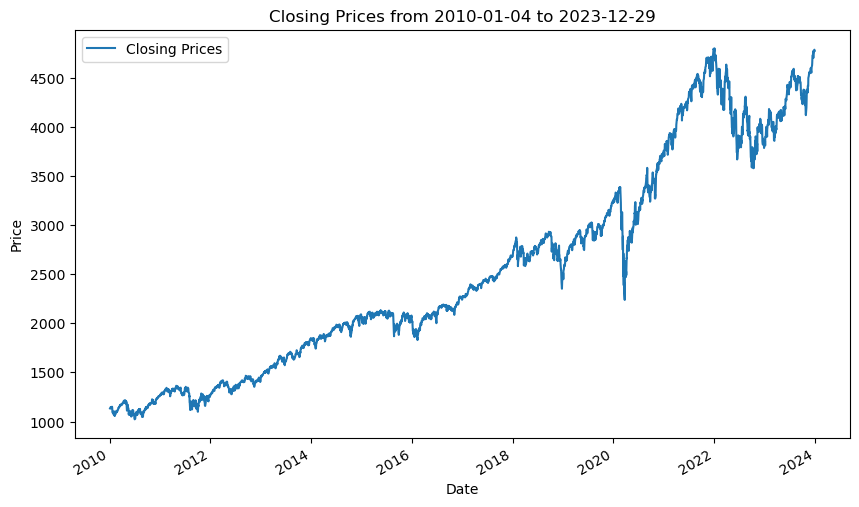

Shapiro-Wilk Test: Statistic=0.9252844452857971, p-value=9.815920580287303e-39
False


,AdjClose,Close,High,Low,Open,Volume
count,3522.000000,3522.000000,3522.000000,3522.000000,3522.000000,3.522000e+03
mean,2535.092035,2535.092035,2548.398393,2519.736800,2534.540220,3.941032e+09
std,1070.516829,1070.516829,1076.721030,1063.824066,1070.377836,9.621445e+08
min,1022.580017,1022.580017,1032.949951,1010.909973,1027.650024,1.025000e+09
25%,1650.479980,1650.479980,1656.674957,1639.840027,1649.520020,3.362412e+09
50%,2264.484985,2264.484985,2271.895020,2258.309937,2267.295044,3.779375e+09
75%,3274.374939,3274.374939,3285.877441,3251.767578,3275.787415,4.315865e+09
max,4796.560059,4796.560059,4818.620117,4780.979980,4804.509766,1.061781e+10


In [19]:
plot_describe()

print(isNormal(df_gspc["Close"].values))

df_gspc.describe()

The `Adjusted Close`, `Close`, and `Open` values have similar statistics, which indicates that the S&P500 companies' prices are adjusted along this period of time.

However, the presence of large standard deviations in price metrics could suggest otherwise. We attribute this issue to:
 - significant increase in price, when comparing 2010 values to 2022.
 - the presence of outliers in the dataset, for example, the price plummeting during COVID

Because GSPC is a broad market indicator, its volumes are quite astronomical in value.

We can expect all of the companies to generally behave like this graph, but values are, of course, different. The graph is a good representation of the overall market behavior, but we must dive into analysis of individual companies to get a better understanding of the data we are going to be working with. Aditionally, the closing price does not follow a normal distribution.

## Preprocessing and Cleanup {#pre}

SInce we previously formatted our data, we can begin to analyze the `csv` contents.

### Missing Values

The first step is to verify if any of them possess any NaN values. If so, those tickers will be identified so that the faulty `csvs` are not passed into the models.

In [20]:
has_nan = [] 

# Iterate over each file 
for ticker in tickers:
    file_path = os.path.join(clean_directory, f"{ticker}.csv")

    # Temporarily transform into dataframe
    df = pd.read_csv(file_path)

    # Returns True if df has at least one NaN
    if df.isna().any().any(): has_nan.append(ticker)

len(has_nan)

0

### Inconsistent Presence in the S&P500

There are no NaN values in any of our csv files. However, due to the nature of the S&P500, there could be companies that are not consistently part of the dataset, from `2010-01-04` up until `2023-12-29`.

We know that Apple, `AAPL`, has never left the S&P500 since its inclusion in 1982. This means that if we crop the csv file to the specified date range, we can determine the number of rows a perfect training dataset should have:

In [21]:
df = pd.read_csv('./csvs_processing/dropped_multiIndex/AAPL.csv')

print("AAPL rows: ", len(df))
df.head()

AAPL rows:  3754


,Date,AdjClose,Close,High,Low,Open,Volume
0,2010-01-04,6.447411,7.643214,7.660714,7.585000,7.622500,493729600
1,2010-01-05,6.458559,7.656429,7.699643,7.616071,7.664286,601904800
2,2010-01-06,6.355826,7.534643,7.686786,7.526786,7.656429,552160000
3,2010-01-07,6.344076,7.520714,7.571429,7.466071,7.562500,477131200
4,2010-01-08,6.386254,7.570714,7.571429,7.466429,7.510714,447610800


If we use all available days, we would have 3754 rows. However, if we use only the interval mentioned in the project statement, we should have as many rows as the GSPC index, if it in fact did remain consistent for all those years. 

In [22]:
start_date = '2010-01-04'
end_date = '2023-12-29'

# Section into only relevant days
interval_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

print(f"GSPC rows == ", len(df_gspc))
print(f"AAPL rows == ", len(interval_df))
print("Are they equal? ", len(df_gspc) == len(interval_df))

GSPC rows ==  3522
AAPL rows ==  3522
Are they equal?  True


After confirming that, in fact, the correct row number should be `3522`, the next step consists of collecting all of the tickers with the same number of rows as the interval inside the `tickers_3522` array, and separate them from all of the files with less than 3522 rows inside the `tickers_less_3522` array.

In [23]:
tickers_3522 = []
tickers_less_3522 = []

# Iterate over each file 
for ticker in tickers:
    file_path = os.path.join(clean_directory, f"{ticker}.csv")

    # Temporarily transform into dataframe
    df = pd.read_csv(file_path)

    start_date = '2010-01-04'
    end_date = '2023-12-29'

    # Filter rows
    interval_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

    if len(interval_df) == 3522: tickers_3522.append(ticker)
    elif len(interval_df) < 3522: tickers_less_3522.append(ticker)

In [24]:
print(len(tickers_3522))
print(len(tickers_less_3522))

430
73


We have some pretty good results. **430 out of the 503** csv files available **show consistency** throghout the **~13 years** we intend to test. 


### Inconsistent Companies

Let's see how many dfifferent row values exist for each of the 73 inconsistent dataframes:

In [25]:
diff_val = {}

# Iterate over each file 
for ticker in tickers_less_3522:
    file_path = os.path.join(clean_directory, f"{ticker}.csv")

    # Temporarily transform into dataframe
    df = pd.read_csv(file_path)

    start_date = '2010-01-04'
    end_date = '2023-12-29'

    # Filter rows
    interval_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

    row_count = len(interval_df)

    if row_count in diff_val: diff_val[row_count].append(ticker)
    else: diff_val[row_count] = [ticker]
        
print(len(diff_val))

66



In order to showcase all of the different values for the inconsistent companies, while avoiding cluttering, we decided to group them by intervals:

In [26]:
min_diff = min(diff_val)
max_diff = max(diff_val)

print(min_diff, max_diff)

0 3521


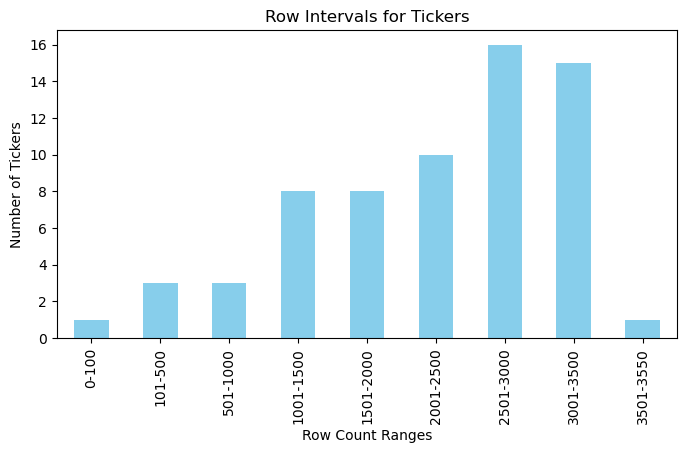

In [27]:
# Group row counts into ranges
ranges = pd.cut(list(diff_val.keys()), bins=[0, 100, 500, 1000, 1500, 2000, 2500, 3000, 3500, 3550], 
                labels=['0-100', '101-500', '501-1000', '1001-1500', '1501-2000', '2001-2500', '2501-3000', '3001-3500', '3501-3550'])
grouped_data = pd.Series(diff_val.keys()).groupby(ranges, observed=False).size()

plt.figure(figsize=(8,4))
grouped_data.plot(kind='bar', color='skyblue')

plt.title('Row Intervals for Tickers')
plt.xlabel('Row Count Ranges')
plt.ylabel('Number of Tickers')
plt.show()


## Risk and Liquidity Assessment {#risk}

This topic delves into specifics for training models. 

Before training, we attempt to mitigate issues that could negativelly impact predictive performance.

 - Already prevented NaN values from affecting our models, as well as non-trainable data types. 

 - Ensured consistency in the extracted csv's by **sectioning the ~13 year period** <sup>1</sup>.


<sup>1</sup> We can guarantee this, because if all datasets have 3522 entries spanning the same 13 years, they must share the same dates, as identical entry counts indicate no missing or extra data. 
Trading occurs on a market-wide schedule, so if one dataset lacks a date (weekends, holidays), it will be missing in every csv, ensuring consistency.

Furthermore, before working on predicting values, we will analyze the intervals of **values we can expect** to obtain, from the 430 valid tickers, using what we already know from the data.

### Price Assessment

Since our **budget is limited** to **10000**, with an action cost of **1**, we will identify **intervals of expected prices**, using results obtained based on price history, since 2010, all the way up to the end of 2023.

In [28]:
diff_prices = {}

# Iterate over each consistent file 
for ticker in tickers_3522:
    file_path = os.path.join(clean_directory, f"{ticker}.csv")

    # Temporarily transform into dataframe
    df = pd.read_csv(file_path)

    start_date = '2010-01-04'
    end_date = '2023-12-29'

    # Filter rows
    interval_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

    avg_close = interval_df.Close.mean()

    if avg_close in diff_prices: diff_prices[row_count].append(ticker)
    else: diff_prices[avg_close] = [ticker]

Once again, we will take on the approach of sectioning into intervals, to facilitate analysis and avoid cluttering.

In [29]:
min_diff = min(diff_prices)
max_diff = max(diff_prices)

print(min_diff, max_diff)

3.713168085518376 2497.074788047535


This significant difference in value is quite interesting.  

The lower stock values can be attributed to higher volumes, or simply the fact that the company is among the best valued markets in its industry, not in general.

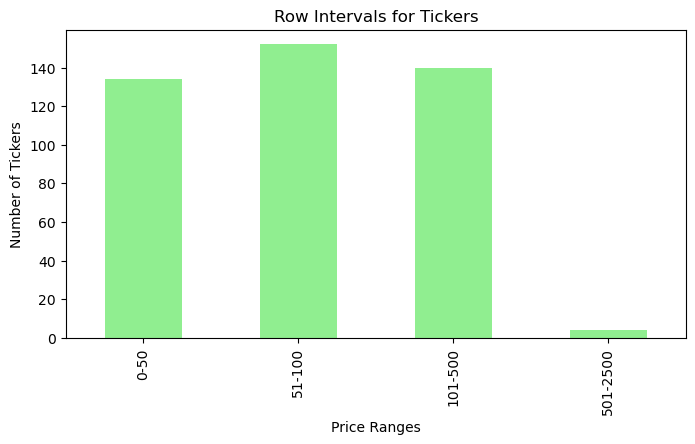

In [30]:
# Group prices into ranges
ranges = pd.cut(list(diff_prices.keys()), bins=[0, 50, 100, 500, 2500], 
                labels = ['0-50', '51-100', '101-500', '501-2500']
)
grouped_data = pd.Series(diff_prices.keys()).groupby(ranges, observed=False).size()

plt.figure(figsize=(8,4))
grouped_data.plot(kind='bar', color='lightgreen')

plt.title('Row Intervals for Tickers')
plt.xlabel('Price Ranges')
plt.ylabel('Number of Tickers')
plt.show()

Through graphical analysis, we find that the vast majority of stocks are priced at under 500\$, which is a relatively low price point, sufficient for experimenting portfolio optimization with some randomized searched methods, such as `MCTS`.

However, we must be careful and take into consideration that the purchase of a 500\$+ stock will severely lower our budget, as those purchases must only be done if the **risk to reward ratio** of potentially missing cheaper stock purchases is justified.\

In order to facilitate that process, we decided to group the tickers of such stocks into separate arrays, which can be used during model implementation:

In [31]:
tickers_500 = []
tickers_500_3000 =[]

# Iterate over each consistent file 
for ticker in tickers_3522:
    file_path = os.path.join(clean_directory, f"{ticker}.csv")

    # Temporarily transform into dataframe
    df = pd.read_csv(file_path)

    start_date = '2024-01-01'
    end_date = '2024-01-31'

    # Filter rows
    interval_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

    avg_close = interval_df.Close.mean()

    if avg_close <= 500: tickers_500.append(ticker)
    else: tickers_500_3000.append(ticker)


In [32]:
print(f"Price <= 500: {len(tickers_500)} different stocks.")
print(f"Price in ]500, 3000]: {len(tickers_500_3000)} different stocks.")

print("Most expensive tickers: \n")
for i in tickers_500_3000: print(i)

Price <= 500: 404 different stocks.
Price in ]500, 3000]: 26 different stocks.
Most expensive tickers: 

ADBE
AZO
BKNG
BLK
COST
EQIX
FICO
GWW
IDXX
INTU
KLAC
LLY
MPWR
MSCI
MTD
NFLX
NVR
ORLY
REGN
ROP
SNPS
TDG
TMO
TPL
UNH
URI


### Risk: standard deviation

In order to evaluate the expected risk of investing in January 2024, we decided to adapt our previous code to detect the most volatile and unstable company stocks.

The recommended criteria to define risk is **standard deviation**.

However, we identified a potential issue with using this method. If we were to plot a graph showing intervals of standard deviation, we could determine that the most stable stocks are those that show the least amount of variation. However, this method does not account for the fact that, for example, a standard deviation of 100 in a price of 5000 is more stable than a standard deviation of 10 in a stock of price 20. 

In order to fix this problem, we decided to look into metrics that are able to represent standard deviation in comparable formats, even for different prices, such as our case. We found that the **Coefficient of Variation (CV)** is the most suitable metric for this purpose:


<center>

$ CV = \frac{\text{Standard Deviation}}{\text{Mean (Stock Price)}} \times 100 $

</center>

Because the CV takes the stock's mean into consideration, it allows us to compare stock volatility across different price points. It's essentially a relative standard deviation percentage.

In [33]:
cv_prices = {}

for ticker in tickers_3522:
    file_path = os.path.join(clean_directory, f"{ticker}.csv")

    df = pd.read_csv(file_path)

    start_date = '2024-01-01'
    end_date = '2024-01-31'
    interval_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

    # Calculate the standard deviation of the 'Close' column in the sectioned data
    cv = (interval_df.Close.std() / interval_df.Close.mean()) * 100

    # Store the standard deviation in the dictionary
    cv_prices[cv] = ticker

In [34]:
min_diff = min(cv_prices)
max_diff = max(cv_prices)

print(min_diff, max_diff)

0.510977902802287 22.223285172847266


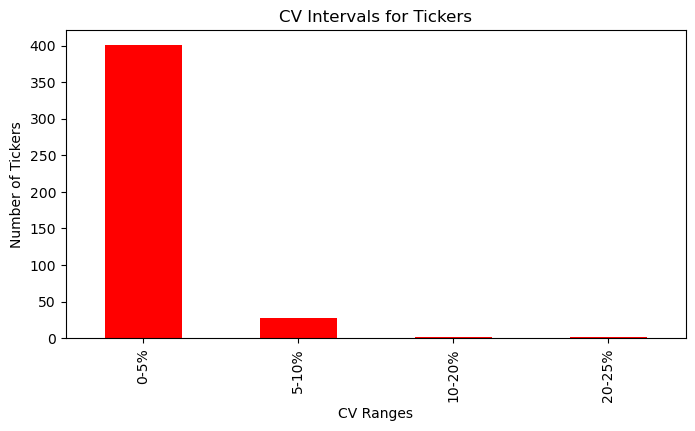

In [35]:
ranges = pd.cut(
    list(cv_prices.keys()),
    
    bins = [0, 5, 10, 20, 25],  
    labels = ['0-5%', '5-10%', '10-20%', '20-25%']  

)

grouped_data = pd.Series(cv_prices.keys()).groupby(ranges, observed=False).size()

plt.figure(figsize=(8, 4))
grouped_data.plot(kind='bar', color='red')
plt.title('CV Intervals for Tickers')
plt.xlabel('CV Ranges')
plt.ylabel('Number of Tickers')
plt.show()


As expected, companies in the S&P500 show low coefficients of variation. This indicates stability for stock markets, throughout the entire month of January 2024. 

We can expect our predicted values to display similar CV values.

### Liquidity: volume

Liquidity is associated with **volume** because trading volume reflects how actively a stock is being bought and sold:

A higher volume means more buyers and sellers are available, which makes it easier to trade the stock quickly without significantly affecting its price. This represents good liquidity. On the other hand, lower volume indicates fewer transactions are being made, which can make it harder to trade the stock, leading to potential delays or price impacts. This represents lower liquidity.

Since we face the same issue as before, we will also be using the coefficients of variation on order to correctly compare stock liquidity:

<center>

$ CV = \frac{\text{Standard Deviation of Volume}}{\text{Mean Volume}} \times 100 $

</center>

In [36]:
cv_volumes = {}

for ticker in tickers_3522:
    file_path = os.path.join(clean_directory, f"{ticker}.csv")
    df = pd.read_csv(file_path)

    start_date = '2024-01-01'
    end_date = '2024-01-31'
    interval_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

    cv = (interval_df.Volume.std() / interval_df.Volume.mean()) * 100
    cv_volumes[cv] = ticker


In [37]:
min_diff = min(cv_volumes)
max_diff = max(cv_volumes)

print(min_diff, max_diff)

11.201256361741066 152.7201245609554


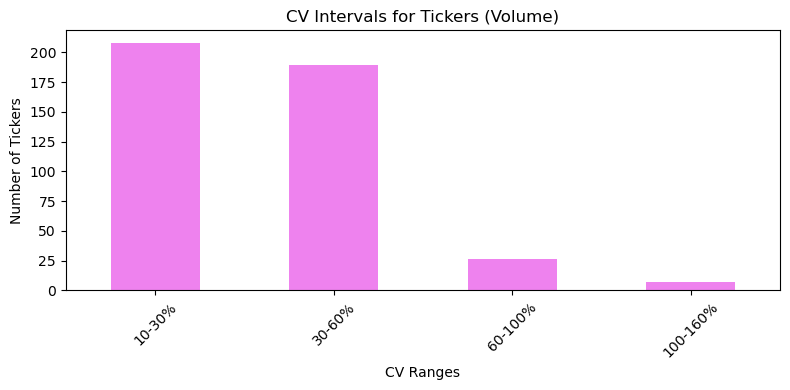

In [38]:
bins = [10, 30, 60, 100, 160]  # Chosen intervals to cover the range adequately
labels = ['10-30%', '30-60%', '60-100%', '100-160%']  # Corresponding labels

# Create ranges for CV volumes
ranges = pd.cut(
    list(cv_volumes.keys()),
    bins=bins,
    labels=labels
)

grouped_data = pd.Series(cv_volumes.keys()).groupby(ranges, observed=False).size()
plt.figure(figsize=(8, 4))
grouped_data.plot(kind='bar', color='violet')  
plt.title('CV Intervals for Tickers (Volume)')
plt.xlabel('CV Ranges')
plt.ylabel('Number of Tickers')
plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()

We consider high liquidity stocks those who show CV >= 100%, which are:

In [39]:
for key in cv_volumes:
    if key >= 100: print(cv_volumes[key])

ADM
DD
EIX
ERIE
JNPR
MMM
ROK


## Model Development {#models}

In this chapter, we will be creating models based on the project statement requirements and existing paper recommendations. All sources are cited along this report and organized in the final chapter **References**.

In order to feed useful pattern recognition data to portfolio optimization algorithms, we decided to implement two different algorithms:

- **LSTM**: First of all, we decided to implement a **Long short-term memort** deep learner to understand data patterns and tendencies regarding the historical data.

- **Random Forest Regressor**: As an additional method of comparison, we implemented an RF Regressor. The detailed process will be explained below.

### LSTM {#lstm}

- **Architecture**: Designed a **double-layered LSTM** to better capture long-term dependencies and complex patterns in sequential stock price data.
- **Hyperparameter Tuning**: Used **Optuna** to optimize key parameters, such as:
  - Look-back window size (history used for predictions).
  - Number of LSTM units (model complexity).
  - Dropout rate (overfitting control).
  - Learning rate (training speed and stability).
- **Sequence Creation**: Transformed historical stock data into sequences of `look_back` days, where each sequence provided input for the LSTM to predict the next day's price.

### Training and Testing Process
- **Data Splitting**:
  - **Training**: Historical data up to 2022.
  - **Validation**: Data from 2023 for hyperparameter tuning.
  - **Testing**: Predictions evaluated on January 2024.
- **Handling Missing Data**: Forward and backward filling ensured no gaps in the input data.
- **Excluded Stocks**: Stocks with insufficient historical data (e.g., `'GEV'`, `'AMTM'`) were removed to maintain dataset integrity.

### Explainability and Insights
We integrated **SHAP (SHapley Additive exPlanations)** to make the model transparent and interpretable:
- **Feature Contributions**: SHAP values revealed the impact of technical indicators (e.g., RSI, MACD) on predictions.
- **Summary Insights**: Validated the importance of engineered features and ensured the model's alignment with financial trends.

### Evaluation Metrics and Results
The model was evaluated using metrics such as:
- **MAE, MSE, and MAPE**: Highlighted accuracy in price prediction.
- **POCID**: Assessed the model's ability to predict price direction (up/down).
  
Visualizations comparing **predicted vs. actual prices** confirmed that the model captures overall trends well, though its performance on volatile stocks requires further optimization.
<center>

<img src="./plots/LSTM_stock.png" alt="_" width="800">

</center>

### LSTM Conclusion
---
The enhanced LSTM model, supported by rigorous tuning and SHAP-based explainability, demonstrated strong predictive capabilities. While improvements in handling volatile stocks are still needed, the model provides accurate forecasts and actionable insights for stakeholders.

---

### Random Forest Regressor

Unlike a standard Random Forest Classifier, which is an ensemble learning method designed for classification tasks and outputs the majority vote or class probabilities, a Random Forest Regressor is used for **regression tasks**, where multiple decision trees are built, and their predictions are averaged to **provide a final continuous output**.

The **Random Forest Regressor model** was meant to be an extra, a comparison point to the neural network. Unfortunately, this proved to be extremely difficult. For this reason, the `random_forest_regressor.ipynb` notebook does not output buying signals, despite possessing all of the scripts and data needed to do so, as well as important conceptions about the **principle of causality** which, in conversation with other colleagues, seemed to be the predominant issue. 

This means that if the model is capable of detecting time-based patters, it can potentially output some very relevant results.

Inside our notebook file, you can find specialized feature extraction and selection, as well as specific feature prediction and data splitting.

#### Initial Model

***Disclaimer***: in order to avoid visual cluttering and allow fair comparison between images, we decided to show every model performance by using the `AAPL.csv` file.  

Our initial model featured a very simple RF Regressor implementation, which uses the same extracted financial metrics of the final model.
These results were, initially, quite surprising: A fast, light model with extremely accurate predictions:

<center>

<img src="./plots/violates_causality.png" alt="_" width="800">

</center>

Of course, we quickly realized some kind of overfitting was happening. 
We discovered that our lagged financial metric features were not being correctly implemented. This is because, as the project statement requires, we must predict an entire month, and train with 13 years of data. Naturally this prediction is correct for the first day of january, because it's only using information from 14 days earlier (all 2023), but every day from there on out will use **information from january 2024 as context**, which inherently **violates the principle of causality**.

### Rules For Prediction

This means that, although indirectly, we were using **January 2024 information to predict January 2024 data**, which outputs extremely overinflated results.

In order to fix this, **we needed to get creative**:

 - Initially, we researched the type of staystical distributions and mathematical patterns our metrics are likely to follow, but the results obtained were not accurate at all, exponentially increasing the RMSE.

So, in order to use only data from 2023 and predict metric behaviour for 2024, we decided to use **LightGBM**:
 - The problem with this is that LightGBM was focusing on feature importance, and because we could only use dates in order to predict metrics, the method was overfitting to the day of the year, and completely disregarding month and year.

Finally, as an attempt to not elevate the execution time and complexity to disproportionate measures:
 - We decided to use **simple RF Regressors**, which were able to consistently predict metrics for 2024 using only the dates!




Now, after using our feature prediction for 2024, we obtained the following results:

<center>

<img src="./plots/rf_standard.png" alt="_" width="800">

</center>

---

**Root Mean Squared Error (RMSE)**: 50.17109657540487

**Mean Absolute Error (MAE)**: 50.03565999187489

**Mean Absolute Percentage Error (MAPE)**: 26.66%

---

We face yet another issue: The pattern in the price change is being correctly predicted, but RMSE values are quite high due to **the lack of correct absolute price adaptation**.

As an attempt to mitigate this issue, we implemented **MinMax** scaling and **binning**. Even though the RMSE **drastically** decreased, the values remained different in scale.

<center>

<img src="./plots/rf_minmax_bin.png" alt="_" width="800">

</center>


Aditionally, we used Random Search to find the best parameters for a portion of the 500 files, assuming that this sample would somewhat represent the general behaviour of the SP500 Index, meaning the most common best settings for that section would represent the best settings for all the data:

<center>

<img src="./plots/rf_optimized.png" alt="_" width="800">

</center>

---

**Root Mean Squared Error (RMSE)**: 0.6897153453821262

**Mean Absolute Error (MAE)**: 0.6873172806971157

**Mean Absolute Percentage Error (MAPE)**: 8.05%

---

Although not present in this notebook, we also implemented some ideas suggested by the professor, such as:

 - Concatenated every Stock data file, using new columns to represent 'Tickers' and 'Sectors', as we were told large amounts of data allowed for extrapolation
 - Used LightGBM in order to improve training speed (later removed due to feature importance issues)

Due to external pressures, such as available working time hindered by the elevated amount of delivery checkpoints, we could not run all of the final codes in time. Furthermore, this is explained in detail in the final parts of our Random Forest Regressor notebook.

We strongly suggest you analyze the sector retrieval and loop for all companies, inside the **important** `random_forest_regressor.ipynb` notebook.

<center>

<img src="./plots/importance_rf.png" alt="_" width="800">    

</center>

### RF Regressor Conclusion

---

Random Forest Regressor was meant to produce buy signals, in order to have a comparison element with the LSTM.

Essentialy, this would be an extra for the project. Unfortunately, we were not able to obtain results we were satisfied with, therefore we will not waste more time than we already have developing such a complex solution to the problem.

Although the professor suggested our model would be capable of extrapolating, external pressures such as the overwhelming ammount of projects and tests scheduled for this delivery week hindered our ability to calmly and timely approach this problem. 

Due to these factors, we still implemented many different ways of mitigating complications we found along the way. When comparing to other groups' projects whose RMSE's were far superior, we noticed and informed them that they were **violating the causality principle**, hence why our results were much inferior. These solutions include:

 - Using MinMax scaling, in order to verify if patterns were correctly detected
 - Using binning to facilitate model training and testing, due to the elevated number of different values for each column
 - Extracted financial metrics and predicting them in order to completely bypass the violation of causality principle
 - Optimized RF parameters
 - Concatenated every Stock data file, using new columns to represent 'Tickers' and 'Sectors', as we were told large ammounts of data allowed for extrapolation
 - Used LightGBM in order to improve training speed (later removed due to feature importance issues)
 - Determined Feature Importance and explained RF's decisions and why they were outputting such results

Despite this, we were able to correctly identify relative changes in price, meaning our model is capable of correctly detecting price changes, while **respecting pertinent prediction principles**.


---

## Portfolio Optimization {#optimization}

This chapter will contain the techniques used to build a portfolio for the month of January 2024. Those techniques will consider the predictions obtained by the LSTM, which were exported and handled in each of the procedures.

We developed two separate notebooks, `montecarlo.ipynb` and `genetic_algorithm.ipynb` which, as the name suggest, focus on the following:

- **Montecarlo**: Search random possibilities, following the best choices guided by the LSTM. The search space will look like this:
![](./plots/montecarlo_DUMMY.png)

- **Genetic Algotithm**: Based on natural selection, mimics the process that drives biological evolution. The genetic algorithm repeatedly modifies a population of individual solutions, looking to find the best porfolio.

## Montecarlo {#montecarlo}

To **simulate the optimization scenario**, and the different possibilities of buys and sells of the different stock tickers and quantity, we implemented a montecarlo approach for this problem. The development of this algorithm took place on the `montecarlo.ipynb` file.

The approach for the problem is to combine the mechanism of generating buying/selling signals of the **Moving Average Agent**, initally implemented on `moving_agent.ipynb`, and the predictions generated by the models.

We did the following procedure to merge those 2 ideas:

- Calculate the price flutuation for each individual stock, predicted by comparing the current day to the upcoming day. 
- We selected an adjustable threshold for a percentage, to be significant enough to generate a buying signal. **It's key that such threshold isn't too small** (and captures insignificant variations), **nor too big** that (so it doesn't capture any significant flutuation at all).

The dataframe generated by the predictive models will have this format:

<center>

| Date       | AAPL | MSFT | META | GOOG | ... |
|------------|------|------|------|------|-----|
| Jan 1st    |      |      |      |      |     |
| Jan 2nd    |      |      |      |      |     |
| Jan 3rd    |      |      |      |      |     |
| ...        |      |      |      |      |     |


</center>

We then need to convert each value to the excepted flutuation for the next day, and use the thresholds already referred.

#### Algorithm Planification

Essentially the algorithm will simulate each day as follows.


---

```py
inventory = {}
total_value = 10000

for day in month:
    diff_ticker_amount = random integer (a, b)       # Generate a random number of stocks to buy total
    buy_tickers = get_buy_tickers()                  # Get the tickers to buy
    buy_distrib = get_buy_distribution(buy_tickers)  # Get the distribution of stocks to buy
    fees = size(buy_distrib)                         # Calculate fees based on the number of different stocks bought
    update_inventory(buy_distrib)                    # Update the inventory with the distribution
```

---


The montecarlo function will then have different mutable arguments: 

- **no_iterations**: number of simulations of the algorithm.
- **balance**: initial balance for the user (default is 10000).
- **min_distr** and **max_distr**: the choice of how many stocks total is bought in a given day, we use *random.randint(min_distr, max_distr)* to decide (default is to buy 3 to 5 per day).
- **diff_ticker_amount**: max amount of different tickers in a day. Let's say 10 tickers have for a day X, a buy signal. Then, we choose diff_ticker_amount and then we distribute the quantity generated. Has to be **lower or equal than min_distr**. (default is 3).

As mentioned by the teacher, since they are already mentioned and implemented, it is not worth to test for different values, since it is very computacionally expensive and not the aim of the project. If needed, the code was adjusted to easily handle changes in these choice parameters.

### Implementation

The algorithm has a lot of auxiliary functions to conduct the distribution of buys for the different stocks, which are not very important to mention in this report. 

The simulation code (short version) is the following:

---

```python
def simulation(df, iteration, inventory, balance=10000, min_distr = 3, max_distr = 5, diff_ticker_amount=3):  
    for index, row in df.iterrows():
        date = row["Date"]
                    
        # Generate stock number and determine tickers to buy
        buy_tickers = get_buy_tickers(date, df)
        if buy_tickers == []: # if no tickers with a buying signal, need exception

            # create variables the same way with null purchase
            purchase = {}
            inventory, inventory_value, balance = update(inventory, purchase, balance, date)

            daily_series[index] = balance + inventory_value
        else:
            no_money = True
            for attempt in range(10): # 10 chances to find a viable purchase
                list_buy_stocks = choose_random_stocks(buy_tickers, diff_ticker_amount)
                purchase = distribute_stocks(random.randint(min_distr, max_distr), list_buy_stocks)
                if calculate_inventory_value(purchase, date) < balance-diff_ticker_amount: # fees included 
                    no_money = False
                    break # can buy 
                else:
                    no_money = True
                    purchase = {}
                    inventory, inventory_value, balance = update(inventory, purchase, balance, date)

                    daily_series[index] = balance + inventory_value
                        
            # Update inventory, value, and balance
            inventory, inventory_value, balance = update(inventory, purchase, balance, date)

            # append to series
            daily_series[index] = balance + inventory_value
            
    return inventory, round(balance + inventory_value), daily_series
```

---

The most important remarks are:
- some days, it might not find any day at all with buying signals;
- the code gives 10 different attempts to find a viable purchase for the avaliable balance. It adds more randomness, instead of forcing to buy cheap ones.
- there are 2 versions of the *simulation()* method, one in which the algorithm allows to simulate the selling of stocks, and one which there is no such option. Results for both will be used.

### Baseline

We imported and cleaned the S&P500 dataset, so that we get a list of the values of the index, for January 2024. We will use it as reference in plots, to make sure that the performance of the algorithm always considers as baseline the S&P500.

Since that index is a **reference for the performance of the american economy**, an increase of 0.5% in our algorithm, on a interval in which the S&P500 increased 1%, can be seen as a loss.

To ensure the values of the index make sense, they need to be scaled to the initial balance for each montecarlo simulation.

*There is a "chapter" explaining that process, and the code in the `montecarlo.ipynb` file.*

### Results

There are 4 different plots obtained during the process, regarding the possibility of selling or not, for the two (tested) different thresholds.

We did not test more thresholds, nor try to tune the parameters, since it was not the aim of this project. 

The four resultant plots are the following:



<center>

<img src="./plots/montecarlo_lstm1_nosell.png" alt="_" width="800">
<img src="./plots/montecarlo_lstm05_nosell.png" alt="_" width="800">
<img src="./plots/montecarlo_lstm1_cansell.png" alt="_" width="800">
<img src="./plots/montecarlo_lstm05_cansell.png" alt="_" width="800">

</center>



### MCTS Conclusion

---

The **algorithm generated a consistent positive return** on an average case, that is irrefutable. However considering that the S&P500 outperformed its normal behaviour, increasing by almost 4% during the month, it's not that big of a win, nor impressive results.

The results were quite different for each of the 4 tries. One very important aspect is that, contrary to what we believed, the **possibility of selling did not improve the algorithm's performance that much**. That is due, of course, to the performance of the LSTM which will be explained in their own notebook** `LSTM.ipynb`.

In some cases, **some of the best scenarios of montecarlo outperformed S&P500**. However, realistically speaking, it is not very viable to consider such metric, since we cannot know, prior to the end of the month, the closing prices, and therefore the best inventory selection during the purchase along the month. Which means, it is more correct to consider the **average performance** instead of the best. **In which the S&P500 (unfortunately) outperformed our algorithm**.

---

## Genetic Algorithm for Portfolio Optimization {#genetic}

To **optimize portfolio allocations** among the S&P 500 stocks, we implemented a Genetic Algorithm (GA)-based approach in the `genetic_algorithm.ipynb` file. The goal is to find the set of stock weights that maximizes the portfolio’s **Sharpe ratio**, providing the best balance between returns and risk.


#### Key Formulas

- **Portfolio Return**:
$$
R_p = \sum_{i=1}^{n} w_i R_i
$$

- **Portfolio Volatility**:
$$
\sigma_p = \sqrt{w^T \Sigma w}
$$

- **Sharpe Ratio** (assuming zero risk-free rate):
$$
\text{Sharpe Ratio} = \frac{R_p}{\sigma_p}
$$

These metrics guide the GA’s optimization toward a portfolio that maximizes risk-adjusted returns.


#### Approach

The GA combines:
- **LSTM Predictions**: Expected stock returns for January 2024.
- **Evolutionary Principles**: Simulating natural selection to iteratively improve the portfolio’s composition.

**Data Input**: We begin with predicted returns from the LSTM model, ensuring the portfolio construction accounts for each stock’s anticipated behavior.

**GA Components**:  
1. **Initialization**: Create a population of random portfolios.  
2. **Fitness Evaluation**: Compute each portfolio’s Sharpe ratio using the formulas above.  
3. **Selection**: Preferentially choose top-performing portfolios to reproduce.  
4. **Crossover**: Merge parent portfolios to produce offspring that may inherit desirable traits (lower volatility, higher returns).  
5. **Mutation**: Randomly tweak weights to explore new possibilities and avoid local optima.  
6. **Elitism**: Retain the best solution each generation to ensure performance does not regress.

**Hyperparameters**:  
- **Population Size (POP_SIZE)** and **Number of Generations (N_GENERATIONS)** control the computational effort and search depth.
- **Mutation Rate (MUTATION_RATE)** and **Crossover Rate (CROSSOVER_RATE)** balance exploration and exploitation.
- **Tournament Selection** and **Single-Point Crossover** were chosen after testing various selection and crossover strategies for optimal performance.


#### Algorithm Planification

Each generation:
- Evaluates all portfolios in the population.
- Selects high-fitness (high Sharpe ratio) portfolios as parents.
- Applies crossover and mutation to form a new generation.
- Tracks the best-performing portfolio’s fitness over time.

**As generations progress, the average fitness improves**, and the GA converges toward a set of weights that maximize the Sharpe ratio.


#### Implementation Details

The `genetic_algorithm.ipynb` includes:
- Functions for initialization, fitness evaluation, selection, crossover, and mutation.
- Calculations for Sharpe ratio improvements over a baseline (equal-weight) portfolio.
- **Interactive widgets (sliders)** that allow stakeholders to dynamically adjust parameters, such as the mutation rate. This feature lets them modify the risk tolerance of the optimization process—higher mutation rates introduce more variability (risk-taking) while lower rates maintain more conservative exploration.

After running the GA:
- We output the **best-performing portfolio’s weights**, its Sharpe ratio, expected return, and volatility.
- We compare these results to real-world data, examining how closely predictions match observed January 2024 outcomes.


#### Visualizations and Insights

**Fitness Evolution Over Generations**:  
   The following line plot shows the improvement of the best Sharpe ratio per generation, confirming that the GA effectively learns and refines its portfolio allocations:

<center>
<img src="./plots/GA_fitness.png" alt="_" width="800">
</center>

**Sector Allocation**:  
   A bar chart of final portfolio weights by sector demonstrates diversification and risk management, ensuring no single sector dominates:

<center>
<img src="./plots/GA_sector.png" alt="_" width="800">
</center>

**Feature Importance (SHAP)**:  
   Using SHAP values, we visualize which stocks most influence the optimized portfolio’s Sharpe ratio, enhancing explainability and trust in the GA’s decisions:

<center>
<img src="./plots/GA_shap.png" alt="_" width="800">
</center>


#### Baseline and Results

Compared to a naive equal-weight portfolio, the GA solution achieved:
- **Higher Sharpe Ratio**: Significantly better risk-adjusted returns.
- **Improved Diversification**: Lower exposure to individual sectors.
- **Favorable Risk Metrics**: Controlled drawdowns and a better Value-at-Risk (VaR).

In some runs, the GA-optimized portfolio outperformed simple heuristics, delivering tangible gains over the one-month period. While results vary, this evolutionary approach proved effective at exploring the high-dimensional search space of stock allocations, identifying allocations that align with the predicted returns.

---

#### GA Conclusion

The Genetic Algorithm provided a **robust and adaptive** method for portfolio optimization. By leveraging LSTM-based predictions and evolutionary mechanics, it enhanced return-risk profiles and offered actionable insights. The inclusion of interactive sliders for adjusting mutation rate ensures stakeholders can tailor the optimization process to their desired risk tolerance. Although not guaranteed to outperform in all scenarios, its systematic and flexible approach makes it a valuable tool for informed, data-driven portfolio construction.

---

# Business Aplicability (#business)

This chapter contains some important aspects relating on the business applicability of deploying our tool in the market.

### Decision-Making Support Tool
First of all, this project serves as a **decision-support tool** for investors, financial analysts, and traders. By forecasting stock prices based **solely on historical patterns**, it enables users to:
- Identify trends in stock prices.
- Simulate investment strategies.
- Optimize trading decisions, especially for **short-term market operations**.

While **it’s not a crystal ball** for predicting market movements, this tool provides **data-driven insights**, empowering users (either analysts, or also taking into account anal) to make more informed decisions.

### Applicability in Finance
Our project consists in trying to **maximize returns via Pattern Recognition**. It is particularly useful for **short-term trading, since it has no other context besides the historical values**. 

However, regarding long-term investing, it is probably better to either use a model that can follow external news data, or the client conduct that research him/herself, since our model does not have access to that information.

The **portfolio optimization** techniques are **very useful to simulate strategies in a controlled environment**. Also, montecarlo can be adapted to simulate buying different stock options the client considers, instead of the ones predicted to rise/go down by the LSTM.

For example, let's say the client believes (and conducts research) on a specific sector. By just a small amount of tuning the scripts, the client can simulate buying different stocks with different quantities during the month. We, as developers, are available to conduct specific tuning to the algorithms, following the requirements.

### Risk Management
Predictive tools can help users **evaluate risks** by preparing for potential adverse price movements. 

Once again, in montecarlo for example, the plots were created with the intention of better **showcasing the risk-reward ratio on each of the thresholds and methods**.

We also used the S&P500 for realistic insights, which can be used to evaluate if the risk on following the algorithms decisions is worth or not.

### Emphasizing the Model’s Limitations

We now will refer some topics that are important to mention, regarding the limitations of our tool usage in the market.

- **Fully Committed to Data Patterns**: This tool is entirely reliant on the **patterns explicit in historical data**. It learns **relationships and trends** within the data but has no awareness of external factors such as:
  - Macroeconomic shifts (e.g. inflation rates).
  - Geopolitical events (e.g. wars, trade policies).
  - Company-specific events (e.g. earnings reports, product launches).
  - Frauds and Earnings Manipulation, CEO resignations.
  - Insiders suddently selling their shares.

<br>

  **Financial markets are influenced by these external factors**, which are beyond the model's scope and need to be studied in parallel with the decisions of the model, prior to the investiment.
  
- Unlike human analysts who integrate external knowledge, this model operates in a **"uninformed environment"**, it cannot account for sudden shocks, like market crashes, and also sector wise flutuations. This limitation makes it a tool for **supplementing human expertise** rather than replacing it.

- **Overfitting to Historical Data**: Models trained on historical data may struggle to generalize, since:
    - Markets evolve, and patterns that existed from 2010–2023 may no longer hold in 2024.
    - Predictions are therefore most useful in **stable market conditions** and less reliable in volatile or unprecedented scenarios as the ones described above.
    
### Conclusion on business applicability
---

This project demonstrates the power of machine learning in recognizing patterns within stock price data, making it a **valuable tool** for informed decision-making. However, its applicability is limited to **pattern-based insights** and **requires human expertise to account for external factors** and ensure ethical, responsible use in the financial market.

For the limitations described, the client must **take precautions and be fully contextualized** on how the tool works and its limitations, before using it.

---


# Ethics {#ethics}

**We strongly suggest the analysis of the `ethics.html` file, submitted alongside this report. This small text represents only a very simple, summarized version of the most important aspect of said file.**

As aforementioned, all data has been preprocessed in such a way that preservation of data and its patterns are guaranteed, and our program is designed as a professional analyst tool, in order to ascertain whether mathematical patterns determined (and explained) by our AI and search methods are useful, and could represent risk-adjusted returns to their client.

# Conclusion {#conclusion}

This project taught us a lot about the stock market. Not only did we learn the most important concepts, but we also explored various financial metrics.

We achieved the primary goal of using forecasting models to simulate January 2024 Close values based on 13 years (2010–2023) of data, followed by portfolio optimization techniques to obtain risk-adjusted returns.

Through this process, we enhanced our ability to develop and optimize methods and models, such as:

- **LSTM**
- **Monte Carlo Tree Search (MCTS)**
- **Random Forest Regressor (RF)**
- **Genetic Algorithms (GA)**

Combining the buying signals generated by the LSTM with the portfolio optimization capabilities of MCTS and GA proved to be highly efficient.

Although our RF model did not produce results, its code is fully functional.



While the project was quite challenging, it encouraged us to think outside the box:


- Ensured models didn’t inadvertently use future information, maintaining time-series causality for realistic outcomes  

- Faced challenges with volatile or less predictable stocks, highlighting the importance of feature engineering and regular validation

- Recognized the need for contextual insights into macroeconomic factors, corporate news, or market shocks to complement model-driven forecasts

Furthermore, in a future implementation of this project, we would:

 - Include enhancing feature sets by incorporating alternative data such as [news](https://github.com/Zdong104/FNSPID_Financial_News_Dataset) and [geopolitical data](https://fred.stlouisfed.org/)
 - Use macroeconomic indicators and sector-specific trends to improve robustness 
 - Use other stock indices, international markets, and different forecasting horizons

***Remarks***

Some notes regarding the decisions and processes that we performed or not and why:

- We considered a different approach for the selection of the best case scenarios and parameters on MCTS:
    1. We considered in each day, to select the best simulations with the best asssets on the end of the day, and diverge from there. However, not only it is not the fundamental principle of the MCTS (random from start to end), but we were adviced not to by the teacher;
    2. All the parameters for the MCTS, all the **mutable parameters** could be random in each iteration, or even target of tuning. Once again we were adviced not to, since it is not the objective of the project.

- We also considered to feed (add) in each day of the iteration, specially on the LSTM, the prior day, to ensure better context:
    1. The assignment **specifically** says we should train with data prior to 2024, and test on january 2024.
    2. We got different answers from both teachers:
        - One said that "that is how they do it on the business", which we agree fully, however it is very computacionally heavy to train many new models for each stock of the 503.
        - The other says it was not necessary, and a wrong methodology.
       Ultimately we did not increased the train size per iteration, which in the end, caused worse results for the LSTM and prohibited the development of a working random forest regressor without crossing the principle of causality.

# References

 - [Wikipedia](https://en.wikipedia.org/wiki/List_of_S%26P_500_companies)
 - [The Random Forest Model for Analyzing and Forecasting the US Stock Market in the Context of Smart Finance](https://arxiv.org/pdf/2402.17194)
 - [Ethics in AI](https://www.cfainstitute.org/sites/default/files/-/media/documents/article/industry-research/Ethics-and-Artificial-Intelligence-in-Investment-Management_Online.pdf)
 - [Ethics in Project Development](https://blog.iil.com/making-ethical-decisions-in-challenging-project-situations/)
 - [Moghar, A., & Hamiche, M. (2020). Stock Market Prediction Using LSTM Recurrent Neural Network. Procedia Computer Science, 170, 1168–1173.](https://doi.org/10.1016/j.procs.2020.03.049)
 - [Zhang, R. (2022). LSTM-based Stock Prediction Modeling and Analysis](https://doi.org/10.2991/aebmr.k.220307.412)
 - [Portfolio Optimization Using Genetic Algorithm](https://github.com/naresh-dscience/Portfolio-Optimization-using-Genetic-Algorithm?)
 - [Roudier, F. (2007). Portfolio Optimization and Genetic Algorithms ](https://ethz.ch/content/dam/ethz/special-interest/mtec/chair-of-entrepreneurial-risks-dam/documents/dissertation/master%20thesis/RoudierMScThesis.pdf?)
 - [Sefiane, S., & Benbouziane, M. (2012). Portfolio Selection Using Genetic Algorithm](https://mpra.ub.uni-muenchen.de/41783/1/MPRA_paper_41783.pdf?)
 - [News](https://github.com/Zdong104/FNSPID_Financial_News_Dataset)
 - [Geopolitical Data](https://fred.stlouisfed.org/)